In [1]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
from data_agent import *
import numpy as np
from data_util import *
import tensorflow as tf
from sklearn_model_hyper import *
import pandas as pd
from stock_agent import *
from backtest import *
from joblib import dump, load
from datetime import datetime, timedelta
from tec_an import *
from bitstamp import *
from process_live_trade import *
from model_winner_select import *

base_dir = "data/"

In [2]:
currency = "btcusd"

full_data = base_dir + "backtest/"
full_data = base_dir + "4jul21/"
#full_data = base_dir + "btcusd/"
data_gen = DataGenerator(random = False, base_dir = full_data)
data_gen.rewind()
data_count = (data_gen.steps - 100)
#data_count = 200000
raw = data_gen.next()

minute = 30

hot_load = True

In [3]:
path = "model/"
files = os.listdir(path)
models = []
for file in files:
    models.append(f"{path}{file}")

#models = ['model/rand']
#models = ['model/quadra']
    
timestamp = int(raw['timestamp'])

In [4]:
results = load('model/rand')

In [5]:
#winner = get_best_model(
#    minutes_list=[minute],
#    result_paths=models,
#    currency_list=[currency],
#    timestamp = timestamp,
#    winner_path = None
#)

In [6]:
#result = winner
#if (winner == None):
result = results[-1]
model = result['model']
window = result['window']
minutes = result['minutes']
step = result['step']
profit = result['profit']
print(f"Minutes={minutes} Window={window} Step={step} | {profit}")
print(f"{model}")


Minutes=30 Window=40 Step=2 | 116.7969034594654
Pipeline(steps=[('normalizer', Normalizer()),
                ('pipeline',
                 Pipeline(steps=[('s',
                                  RFECV(estimator=ExtraTreesClassifier(max_features=0.3,
                                                                       random_state=42),
                                        scoring='recall')),
                                 ('m',
                                  RandomForestClassifier(bootstrap=False,
                                                         criterion='entropy',
                                                         max_features=0.1,
                                                         random_state=42))]))])


In [7]:
import numpy as np
import matplotlib.pyplot as plt
def get_charts(stock_data):
    fig = plt.figure()
    ax = plt.axes()
    x = stock_data
    plt.plot(x, linewidth=1)
    #plt.grid(b=True, color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.show()


In [8]:
def get_online_data(minutes,
                    val_start,
                    val_end,
                    source_data_generator, 
                    load_from_disk, file_prefix = ""):
    
    online = OnLineDataProvider(
                 source_data_generator = source_data_generator,
                 minutes = minutes,
                 train_keys = [],
                 train_limit = 1000,
                 val_limit = 1000,
                 val_keys = [currency],
                 val_start = val_start,
                 val_end = val_end,
                 train_start_list = val_start
    )

    online_path = f'data/online{file_prefix}_{minutes}'
    
    online.load_val_cache([currency], val_start, val_end)
    
    return online

In [9]:

on_raw_data = lambda raw: print(raw)

data_gen.rewind()

first = data_gen.next()

In [10]:
agent_reference, back_reference, stock_reference = get_agent(minutes = minutes,
                                win = window,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True)
prices = []
agent_reference.on_closed_price = lambda price: prices.append(price)
#agent.ohlc['open'].plot()

BackTest (pending_sell_steps=2 sell_on_profit=True value=100)
https://www.bitstamp.net/api/v2/ohlc/btcusd/?&currency_pair=btcusd&step=1800&limit=1000&start=1624538981


  0%|          | 0/501 [00:00<?, ?it/s]

###### Past report(501): 2021-06-24 12:30:00(1624537800) - 2021-07-04 22:30:00(1625437800) ######
Metric: {'recall': 0.6514084507042254, 'precision': 0.5692307692307692, 'f1': 0.6075533661740559, 'accuracy': 0.5229540918163673}
1.14882% -> 101.14881500843086
Positive: 99 Negative: 43
###### - ######


In [11]:
data_gen.rewind()


reference_list = []
#data_count
for i in tqdm(range(data_count)):
    raw = data_gen.next()
    price = raw[PRICE_KEY]
    amount = raw[AMOUNT_KEY]
    timestamp = raw[TIMESTAMP_KEY]
    timestamp_pd = pd.to_datetime(timestamp, unit='s')
    reference_list.append([timestamp_pd, price])


100%|██████████| 301794/301794 [01:23<00:00, 3630.42it/s]


In [12]:
DATE = 'Date'
df = pd.DataFrame(agent_reference.list, columns = [DATE, CLOSE])
df = df.set_index(pd.DatetimeIndex(df[DATE]))

All data reference


<AxesSubplot:xlabel='Date'>

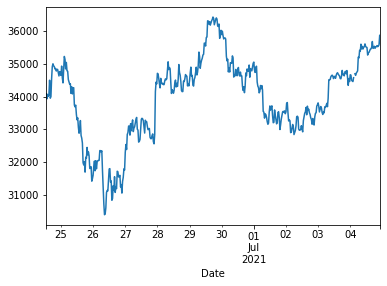

In [13]:
time = df[CLOSE].resample(agent_reference.resample)
ohlc = time.ohlc()
print("All data reference")
ohlc['open'].plot()

In [14]:
reference_list[0]

[Timestamp('2021-07-04 22:49:41'), 35330.0]

In [15]:
agent, back, stock = get_agent(minutes = minutes,
                                win = window,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True)
prices = []

BackTest (pending_sell_steps=2 sell_on_profit=True value=100)
https://www.bitstamp.net/api/v2/ohlc/btcusd/?&currency_pair=btcusd&step=1800&limit=1000&start=1624538981


  0%|          | 0/501 [00:00<?, ?it/s]

###### Past report(501): 2021-06-24 12:30:00(1624537800) - 2021-07-04 22:30:00(1625437800) ######
Metric: {'recall': 0.6514084507042254, 'precision': 0.5692307692307692, 'f1': 0.6075533661740559, 'accuracy': 0.5229540918163673}
1.14882% -> 101.14881500843086
Positive: 99 Negative: 43
###### - ######


In [16]:
data_gen.rewind()
agent.save_history = True
#data_count
for i in range(data_count):
    raw = data_gen.next()
    agent.on_new_raw_data(raw)

2021-08-15 23:09:28.856449 ModelAgent(35340.23): 2021-07-04 23:00:04(1625439604) UP
2021-08-15 23:09:28.856634 BackTest: Bought: 35340.23
2021-08-15 23:09:30.603625 ModelAgent(35415.34): 2021-07-04 23:30:08(1625441408) DOWN
2021-08-15 23:09:30.603802 BackTest: SOLD >>>> Result: PROFIT 0.2125 total: 100.21253398746978
2021-08-15 23:09:32.145874 ModelAgent(35247.7): 2021-07-05 00:00:17(1625443217) UP
2021-08-15 23:09:32.146047 BackTest: Bought: 35247.7
2021-08-15 23:09:34.134317 ModelAgent(34922.82): 2021-07-05 00:30:08(1625445008) UP
2021-08-15 23:09:35.826361 ModelAgent(34898.82): 2021-07-05 01:00:40(1625446840) UP
2021-08-15 23:09:37.452607 ModelAgent(34639.91): 2021-07-05 01:30:15(1625448615) UP
2021-08-15 23:09:40.625783 ModelAgent(34560.8): 2021-07-05 02:00:08(1625450408) DOWN
2021-08-15 23:09:40.625957 BackTest: SOLD >>>> Result: LOSS -1.9488 total: 98.26375435078428
2021-08-15 23:09:44.896822 ModelAgent(34477.16): 2021-07-05 02:30:40(1625452240) UP
2021-08-15 23:09:44.897014 Back

In [17]:
agent.report()

1625439604 - 35340.23 - True
1625441408 - 35415.34 - False
1625443217 - 35247.7 - True
1625445008 - 34922.82 - True
1625446840 - 34898.82 - True
1625448615 - 34639.91 - True
1625450408 - 34560.8 - False
1625452240 - 34477.16 - True
1625454002 - 34430.21 - True
1625455806 - 34426.56 - False
1625457601 - 34363.72 - False
1625459423 - 34245.31 - False
1625461201 - 34199.5 - True
1625463001 - 34112.89 - False
1625464817 - 34344.29 - True
1625466630 - 34299.57 - True
1625468403 - 34295.01 - True
1625470202 - 34154.96 - False
1625472001 - 34269.56 - False
1625473811 - 34174.91 - True


In [18]:
val_start = int(first['timestamp'])
val_end = int(raw['timestamp'])

start_string = pd.to_datetime(val_start, unit='s')
end_string = pd.to_datetime(val_end, unit='s')

print(f"{start_string}({val_start}) -> {end_string}({val_end})")

2021-07-04 22:49:41(1625438981) -> 2021-07-05 08:50:02(1625475002)


In [19]:
back.on_down(back.buy_price, back.buy_price)
back.report()

-101.88125% -> -1.881249499106545
Positive: 2 Negative: 3


<AxesSubplot:xlabel='Date'>

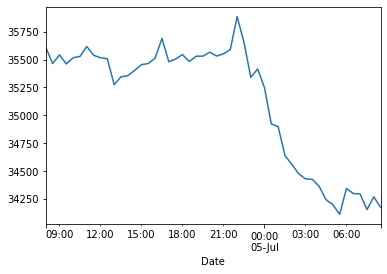

In [20]:
agent.ohlc[-50:]["open"].plot()
#agent.ohlc[1:]

In [21]:
tec = TecAn(windows = window, windows_limit = 100)
source_data_generator = SourceDataGenerator(tec = tec)

In [22]:
online = get_online_data(minutes = minute, 
                 source_data_generator = source_data_generator, 
                 load_from_disk = True, 
                 file_prefix = "____",
                 val_start = val_start,
                 val_end = val_end)

https://www.bitstamp.net/api/v2/ohlc/btcusd/?&currency_pair=btcusd&step=1800&limit=1000&start=1625438981


  0%|          | 0/22 [00:00<?, ?it/s]

In [23]:
x_list, price_list, time_list = online.load_val_data(currency)

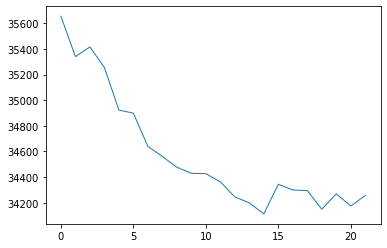

22


In [24]:
get_charts(price_list)
print(len(price_list))

In [25]:
agent_array, back_array, stock_array = get_agent(minutes = minutes,
                                win = window,
                                step = step,
                                currency = currency,
                                hot_load = hot_load,
                                model = model,
                                timestamp = int(first['timestamp']),
                                simulate_on_price = True)

BackTest (pending_sell_steps=2 sell_on_profit=True value=100)
https://www.bitstamp.net/api/v2/ohlc/btcusd/?&currency_pair=btcusd&step=1800&limit=1000&start=1624538981


  0%|          | 0/501 [00:00<?, ?it/s]

###### Past report(501): 2021-06-24 12:30:00(1624537800) - 2021-07-04 22:30:00(1625437800) ######
Metric: {'recall': 0.6514084507042254, 'precision': 0.5692307692307692, 'f1': 0.6075533661740559, 'accuracy': 0.5229540918163673}
1.14882% -> 101.14881500843086
Positive: 99 Negative: 43
###### - ######


In [26]:
agent_array.save_history = True
for idx in range(len(price_list)):
    price = price_list[idx]
    time = time_list[idx]
    order = [[f"{price}", f"{price}"]]
    amount = 0.0
    agent_array.process_data(price, amount, time, order, order)

2021-08-15 23:11:02.982190 ModelAgent(35340.23): 2021-07-04 23:00:00(1625439600) UP
2021-08-15 23:11:02.982517 BackTest: Bought: 35340.23
2021-08-15 23:11:03.029785 ModelAgent(35415.34): 2021-07-04 23:30:00(1625441400) DOWN
2021-08-15 23:11:03.030057 BackTest: SOLD >>>> Result: PROFIT 0.2125 total: 100.21253398746978
2021-08-15 23:11:03.078310 ModelAgent(35255.0): 2021-07-05 00:00:00(1625443200) UP
2021-08-15 23:11:03.078565 BackTest: Bought: 35255.0
2021-08-15 23:11:03.120107 ModelAgent(34922.82): 2021-07-05 00:30:00(1625445000) UP
2021-08-15 23:11:03.162544 ModelAgent(34898.82): 2021-07-05 01:00:00(1625446800) UP
2021-08-15 23:11:03.207801 ModelAgent(34639.91): 2021-07-05 01:30:00(1625448600) UP
2021-08-15 23:11:03.251943 ModelAgent(34560.8): 2021-07-05 02:00:00(1625450400) UP
2021-08-15 23:11:03.293585 ModelAgent(34477.16): 2021-07-05 02:30:00(1625452200) UP
2021-08-15 23:11:03.334898 ModelAgent(34430.21): 2021-07-05 03:00:00(1625454000) UP
2021-08-15 23:11:03.371711 ModelAgent(3442

In [27]:
back_array.on_down(back_array.buy_price, back_array.buy_price)
back_array.report()

-2.18921% -> 97.81079350089136
Positive: 2 Negative: 3


In [28]:
agent_array.report()

1625439600 - 35340.23 - True
1625441400 - 35415.34 - False
1625443200 - 35255.0 - True
1625445000 - 34922.82 - True
1625446800 - 34898.82 - True
1625448600 - 34639.91 - True
1625450400 - 34560.8 - True
1625452200 - 34477.16 - True
1625454000 - 34430.21 - True
1625455800 - 34426.56 - False
1625457600 - 34363.72 - False
1625459400 - 34245.31 - False
1625461200 - 34199.5 - True
1625463000 - 34112.89 - False
1625464800 - 34344.29 - True
1625466600 - 34299.57 - True
1625468400 - 34295.01 - True
1625470200 - 34149.71 - False
1625472000 - 34269.56 - True
1625473800 - 34174.91 - True
1625475600 - 34256.42 - False


In [29]:
def eval_step_(model, train_set, step, provider, verbose = False):

    valX, valY, times = provider.load_val_data(train_set)
    
    x, y, closed_prices = get_sequencial_data(valX, valY, step)
    
    preds = model.predict(valX)

    metrics = {}
    metrics["recall"] = recall_score(y, preds)
    metrics["precision"] = precision_score(y, preds)
    metrics["f1"] = f1_score(y, preds)
    metrics["accuracy"] = accuracy_score(y, preds)
    metrics["roc_auc"] = roc_auc_score(y, preds)
    
    back = BackTest(value = 100, 
                    verbose = verbose, 
                    sell_on_profit = False,
                    pending_sell_steps = step)
    
    back = backtest_model(model, valX, valY, back)
    
    get_charts(valY)
    
    return back, metrics
    

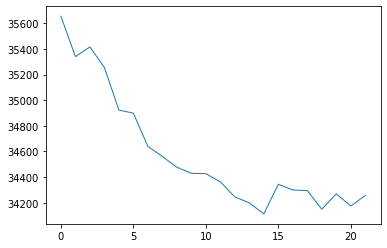

In [30]:
back, metrics = eval_step_(model, currency, step, online, verbose = False)

In [31]:
print(metrics)
back.report()

{'recall': 0.2, 'precision': 0.07692307692307693, 'f1': 0.1111111111111111, 'accuracy': 0.2727272727272727, 'roc_auc': 0.24705882352941172}
-3.2558% -> 96.74419809280852
Positive: 1 Negative: 4
